# Pre-trained Model

In this experiment, we load a pre-trained model to solve the image classification task in the CIFAR10 dataset. PyTorch provides a wide variety of pre-built architectures, such as AlexNet, Inception, MobileNet, etc., for the majority of these architectures, PyTorch also gives us the option to load the weights pre-trained on ImagerNet. For this specific experiment, we implement a ResNet model, specifically ResNet18, using its pre-trained weights.

In [1]:
# Display image
from matplotlib.pyplot import imshow
# General purposes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# torch custom module
import torch_utils
# PyTorch stuff
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim
# ResNet model
from torchvision.models import resnet18

# Specifies which GPUs will be used
import os
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='1'

## 1. Dataset

In the next cell, we define the set of transforms applied to the images before passing to the network. Since we will be using a pre-trained network, we need to be very careful when applying transforms to the images because the network is used to see images with a defined size, whose values lie within a specific range. Fortunately, in most cases, PyTorch tells us what transforms we need to implement when using each of its pre-trained models. 

In this case, the right image preprocessing for a ResNet model is the following. 

In [2]:
custom_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Now, we download the CIFAR10 data set.

In [3]:
train_data = CIFAR10(root='../data', train=True, download=True, transform=custom_transforms)
valid_data = CIFAR10(root='../data', train=False, download=True, transform=custom_transforms)

Files already downloaded and verified
Files already downloaded and verified


We can create a list of the classes.

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us take a look at a sample of the images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
frog


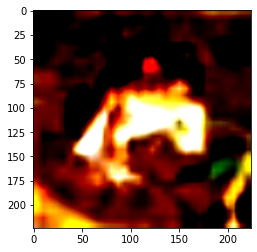

In [5]:
image, label = train_data[0]
print(classes[label])
imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
cat


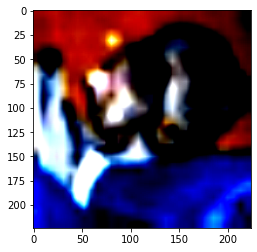

In [6]:
image, label = valid_data[0]
print(classes[label])
imshow(image.permute(1, 2, 0))

To pass the data to the neural network, we need to use a dataloader object.

In [7]:
train_dataloader = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_data, batch_size=5, shuffle=True)

## 2. Network

In this section, we will define the architecture of the network we are going to use. As mentioned above, we wish to use a pre-trained ResNet model. 

In the next cell, we define a function that returns, after providing the number of classes and specifying if we want to load the pre-trained weights into our network, a ResNet18 architecture ready for use.

In [8]:
def resnet_based_model(num_classes = 10, pretrained = False):

    network = resnet18(pretrained = pretrained)
    fc_input_size = network.fc.in_features
    network.fc = nn.Linear(in_features = fc_input_size, out_features = num_classes, bias = True)

    return network

Let us take a moment to try to make sense of what the above code is doing. First, we call the resnet18 module, which returns the ResNet18 architecture, which outputs a vector of size 1000; this makes sense if we consider that ResNet architectures were created to accomplish the ImageNet classification problem, which has 1000 classes. After that, we replace this fully connected layer for another fully connected whose output size fits our specific problem's number of classes.

Given that the resnet18 module delivers a function, not a class, we cannot create a son class that adds the summary functionality. However, we can display a summary of the model as follows.

In [9]:
resnet18_net = resnet_based_model(num_classes=10, pretrained=True)
torch_utils.network_summary(resnet18_net, input_size=(3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

## 3. Training the Model

### 3.1 _Freezing_ the Weights

Since we are using a pre-trained model, we wish to train only the last layer's weights, _freezing_ the weights of the rest of the network during the training process. This procedure is known as transfer learning. 



In [10]:
for name, parameters in resnet18_net.named_parameters(): 
    # We freeze all the layers but the normalization ones and the fully connected layer
    if ('bn' not in name) and ('fc' not in name):
        parameters.requires_grad = False

We can check the number of trainable parameters by displaying the model's summary.

In [11]:
torch_utils.network_summary(resnet18_net, input_size=(3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]        

### 3.2 Loss Function and Optimizer

Now, we define the loss function and the optimizer for our model.

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_net.parameters(), lr=0.001, momentum=0.9)

### 3.3 Training on GPU

To train our model on a GPU, we need to specify which GPU we want to use to store the network and the data.

In [13]:
if torch.cuda.is_available():
    fancy_gpu = torch.device('cuda')

### 3.4 Training 

Finally, we train de model.

In [14]:
num_epochs = 20

trained_net, training_history = torch_utils.train_network(
                                    network = resnet18_net, 
                                    epochs = num_epochs, 
                                    train_dataloader = train_dataloader, 
                                    valid_dataloader = valid_dataloader, 
                                    loss_fn = loss_fn, 
                                    optimizer = optimizer,
                                    save_history = False,
                                    device = fancy_gpu)

Epoch: 1 || Train loss = 0.68, Train Acc = 77.61, Valid Loss = 0.32, Valid Acc = 89.52
Epoch: 2 || Train loss = 0.53, Train Acc = 82.69, Valid Loss = 0.3, Valid Acc = 90.32
Epoch: 3 || Train loss = 0.5, Train Acc = 83.53, Valid Loss = 0.29, Valid Acc = 90.04
Epoch: 4 || Train loss = 0.48, Train Acc = 84.26, Valid Loss = 0.24, Valid Acc = 91.94
Epoch: 5 || Train loss = 0.46, Train Acc = 84.76, Valid Loss = 0.27, Valid Acc = 90.94
Epoch: 6 || Train loss = 0.45, Train Acc = 85.42, Valid Loss = 0.23, Valid Acc = 91.96
Epoch: 7 || Train loss = 0.44, Train Acc = 85.61, Valid Loss = 0.25, Valid Acc = 91.49
Epoch: 8 || Train loss = 0.43, Train Acc = 85.78, Valid Loss = 0.24, Valid Acc = 91.93
Epoch: 9 || Train loss = 0.42, Train Acc = 86.24, Valid Loss = 0.25, Valid Acc = 91.85
Epoch: 10 || Train loss = 0.41, Train Acc = 86.58, Valid Loss = 0.24, Valid Acc = 91.87
Epoch: 11 || Train loss = 0.41, Train Acc = 86.83, Valid Loss = 0.27, Valid Acc = 91.22
Epoch: 12 || Train loss = 0.39, Train Acc =

### 3.5 Training History

Now, we can plot the training history. First, we plot the loss' history during the training.

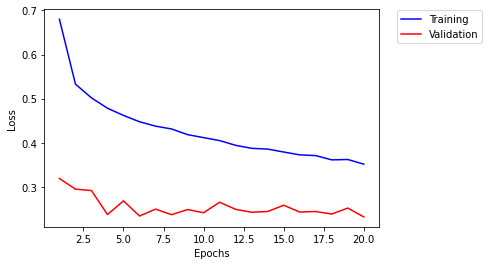

In [16]:
loss_train_history = training_history['train_loss']
plt.plot(np.arange(1,len(loss_train_history)+1), loss_train_history, color= 'blue', label = 'Training')
loss_valid_history = training_history['valid_loss']
plt.plot(np.arange(1,len(loss_valid_history)+1), loss_valid_history, color= 'red', label = 'Validation')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

Now the accuracy's history.

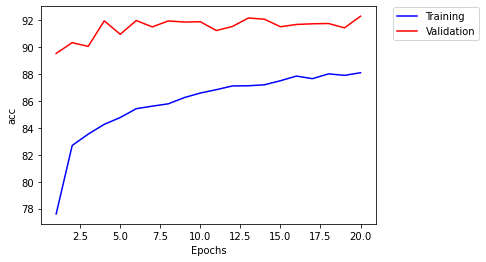

In [17]:
loss_train_history = training_history['train_acc']
plt.plot(np.arange(1,len(loss_train_history)+1), loss_train_history, color= 'blue', label = 'Training')
loss_valid_history = training_history['valid_acc']
plt.plot(np.arange(1,len(loss_valid_history)+1), loss_valid_history, color= 'red', label = 'Validation')

plt.xlabel('Epochs')
plt.ylabel('acc')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1) 

## 4. Testing

When creating and training machine learning models, one has to have three datasets, the training set, the validation set and the testing set. The testing set aims to help us evaluate the model's performance once the training process is finished, in contrast with the validation set, used to track the model's performance during the training process. 

Unfortunately, the CIFAR10 dataset only provides the training and the validation sets. However, for illustrative purposes only, down bellow, we evaluate our model on the validation set. We want to stress that, in real-life applications or research, we must perform the testing of our model on a set that's disjoint from the training and validation sets.

In [18]:
test_loss, test_acc = torch_utils.evaluate(network = resnet18_net, dataloader = valid_dataloader, loss_fn = loss_fn, device = fancy_gpu)
print('test loss = ' + str(round(test_loss,2)) + ', test accuracy = ' + str(round(test_acc,2)))

test loss = 0.23, test accuracy = 92.28
